Project 3: Classification

The goal of this project is to build a machine learning model to predict a category for a dataset.

For this project, I use Sonoma County's Animal Shelter Intake and Outake data to predict the likelihood an animal will be returned from adoption.

In this notebook, I explore different classification functions using my dataset. I'll be using the models I build to help me determine if I need to do more feature engineering or include more features. The goal of this notebook is to try out a couple models and determine my final modeling algorithm.

### Table of Contents
1. Imports
2. Data Preparation
3. kNN
4. Decision Tree
5. Random Forest
6. Logistic Regression
7. Naive Bayes
8. XGBoost
9. Final Model Selection

#### 1. Imports

In [2]:
# standard imports
import pandas as pd
import numpy as np 
import pickle

# classification imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as prfs_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb

# oversampling my minority class and undersampling my majority class
import imblearn.over_sampling
import imblearn.under_sampling

### 2. Data Preparation

Pretty much all of my features are categorical in nature. The only continous variable I have is age. I also have some missing values, which I'll need to deal with when building some of my models.

The data transformations I need to consider because my data is imbalanced:
* Minority oversampling
* Majority Undersampling
* Assign class weights to my classification functions
* Adjust probability thresholds

What metrics do I want to look at?<br/>
True positive: my model predicted the animal is an adoption return and it actually is<br/>
True negative: my model predicted the animal is not an adoption return and it isn't an adoption return<br/>
False positive: my model predicted the animal is an adoption return, but it's not an adoption return<br/>
False negative: my model predicted the animal is not an adoption return, but it is an adoption return<br/>
* Precision: true positives / (true positive + false positive) 
* Recall: true positives / (true positive + false negative)
* F1 score: harmonic mean of Precision and Recall
* Accuracy: Observations correctly classifed / all observations (note: because my dataset is imbalanced, I do not want to use accuracy as my metric)
* AUC: a value close to 1 means there's good seprability between your two classes; 0.5 means no class separation; 0 means the model is predicting negatives as positives and positives as negatives

In [3]:
# load in latest cleaned dataframe
with open("data/animal_cleaned_df.pickle", 'rb') as read_file:
    animal_df = pickle.load(read_file)

In [4]:
animal_df.head()

,name,type,breed,color,sex,size,date_of_birth,intake_date,days_in_shelter,intake_type,...,breed_1,breed_2,clean_name,has_name,age,top_breeds,top_colors,pit_bull,adopt_return,intake_location
0,NICO,DOG,POMERANIAN,BROWN,Male,MED,2016-02-01,2020-07-12,0,STRAY,...,POMERANIAN,NaN,NICO,1,5.0,OTHER,BROWN,0,0,SANTA ROSA
1,NaN,DOG,PIT BULL/MIX,BLACK/WHITE,Female,MED,NaT,2020-07-12,0,STRAY,...,PIT BULL,MIX,NaN,0,NaN,PIT BULL/MIX,BLACK/WHITE,1,0,SONOMA COUNTY
2,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaT,2020-01-19,4,STRAY,...,GERM SHEPHERD,NaN,SKY,1,NaN,GERM SHEPHERD,BLACK/TAN,0,0,SONOMA COUNTY
3,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,2015-04-06,2017-08-30,35,STRAY,...,BEAGLE,NaN,COCO,1,6.0,OTHER,OTHER,0,0,SANTA ROSA
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,2011-01-23,2015-01-07,17,STRAY,...,LABRADOR RETR,MIX,SUZIE,1,10.0,OTHER,BLACK,0,0,SANTA ROSA


In [5]:
animal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19690 entries, 0 to 19689
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  14679 non-null  object        
 1   type                  19690 non-null  object        
 2   breed                 19690 non-null  object        
 3   color                 19690 non-null  object        
 4   sex                   19690 non-null  object        
 5   size                  19659 non-null  object        
 6   date_of_birth         14953 non-null  datetime64[ns]
 7   intake_date           19690 non-null  datetime64[ns]
 8   days_in_shelter       19690 non-null  int64         
 9   intake_type           19690 non-null  object        
 10  intake_subtype        19690 non-null  object        
 11  intake_condition      19690 non-null  object        
 12  intake_jurisdiction   19690 non-null  object        
 13  outcome_jurisdic

In [6]:
columns_to_keep = ["type", "size", "age", "gender", "has_name", "spay_neuter", "intake_condition", "pit_bull", "intake_location", "adopt_return"]
class_df = animal_df[columns_to_keep].copy()

# dropping 31 rows where size is null (0.1% of my data)
print(class_df[class_df["size"].isnull()].shape)
class_df = class_df[class_df["size"].notna()].reset_index(drop=True)

# Since I calculated age to be a whole number, I impute with the median value
print(class_df["age"].mean(), class_df["age"].median())
class_df["age"].fillna(class_df["age"].median(), inplace=True)

(31, 10)
7.883664858348403 7.0


In [7]:
class_df.info() # double check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19659 entries, 0 to 19658
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              19659 non-null  object 
 1   size              19659 non-null  object 
 2   age               19659 non-null  float64
 3   gender            19659 non-null  object 
 4   has_name          19659 non-null  int64  
 5   spay_neuter       19659 non-null  int64  
 6   intake_condition  19659 non-null  object 
 7   pit_bull          19659 non-null  int64  
 8   intake_location   19659 non-null  object 
 9   adopt_return      19659 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.5+ MB


In [8]:
def oversample_data(X, y, oversample_amnt):
    '''
    This function returns data that oversamples the minority class.
    Input:
    - X (DataFrame): dataframe of features to be oversampled
    - y (Series): series of target variable
    - oversample_amnt (int): multiplcative factor to oversample by (i.e. 2 times or 3 times)
    Output:
    - X_os (DataFrame): oversampled X dataframe
    - y_os (Series): oversampled y series
    
    '''
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    ratio = {1: (n_pos * oversample_amnt), 0: n_neg}
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=202)
    X_os, y_os = ROS.fit_sample(X, y)
    
    return X_os, y_os

In [9]:
def smote_data(X, y, oversample_amnt):
    '''
    This function returns data with synthetic minority over-sampling.
    Input:
    - X (DataFrame): dataframe of features to be oversampled
    - y (Series): series of target variable
    - oversample_amnt (int): multiplicative factor to create synthetic minority samples by (i.e. 2 times or 3 times)
    Output:
    - X_os (DataFrame): SMOTE oversampled X dataframe
    - y_os (Series): SMOTE oversampled y series
    
    '''
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    ratio = {1: (n_pos * oversample_amnt), 0: n_neg}

    smotenc = imblearn.over_sampling.SMOTENC(categorical_features=[0,1,3,4,5,6,7,8], sampling_strategy=ratio, random_state=202)
    X_smote, y_smote = smotenc.fit_resample(X, y)
    
    return X_smote, y_smote

In [10]:
def undersample_data(X, y, undersample_amnt):
    '''
    This function produces data that undersamples the majority class.
    Input:
    - X (DataFrame): dataframe of features to be undersampled
    - y (Series): series of target variable
    - undersample_amnt (float): ratio to undersample by (i.e. 1/2 or 1/3)
    Output:
    - X_us (DataFrame): undersampled X dataframe
    - y_us (Series): undersampled y series
    
    '''
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    ratio = {1:n_pos, 0:int(n_neg * undersample_amnt)}
    
    ROS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=202)
    X_us, y_us = ROS.fit_sample(X, y)
    
    return X_us, y_us

In [11]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    '''
    This function plots a confusion matrix for true vs predicted values.
    Input:
    - y_true (array): list of actual y values
    - y_pred (array): list of predicied y values
    - xlabels (list): list to label the x tick marks
    - ylabels (list): list to label the y tick marks
    - model_name (str): name of the model   
    '''    
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, cmap=plt.cm.Blues, annot=True, fmt='d', xticklabels=["No Return", "Adoption Return"], yticklabels=["No Return", "Adoption Return"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix');

### 3. kNN: K Nearest Neighbors Classifier
My data needs to be prepped and transformed before I can use the kNN algorithm. I need to scale my age column. I also need to dummify my variables because kNN doesn't work with categorical data. It needs to calculate distances.

In [12]:
# scale age column to perform K nearest neighbors
X = class_df.drop(columns=["adopt_return"])
scaler = StandardScaler()
X["age"] = scaler.fit_transform(X["age"].values.reshape(-1,1))

# make dummy columns
X = pd.get_dummies(X)

y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [13]:
# Looks like kNN almost always predicts my majority class looking at the ROC/AUC score
knn_results = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, knn_pred)
    precision, recall, fscore, support = prfs_score(y_test, knn_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, knn_pred)
    
    model_scores_dict = {
                        'Model': 'kNN',
                        'Sampling Strategy': 'None',
                        'Parameter_1': f'Neighbors: {i}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    knn_results.append(model_scores_dict)
                       
knn_results_df = pd.DataFrame(data=knn_results)
knn_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,kNN,None,Neighbors: 1,NaN,0.97,0.07,0.06,0.07,0.52
1,kNN,None,Neighbors: 2,NaN,0.98,1.00,0.01,0.03,0.51
2,kNN,None,Neighbors: 3,NaN,0.98,0.20,0.03,0.05,0.51
3,kNN,None,Neighbors: 4,NaN,0.98,0.00,0.00,0.00,0.50
4,kNN,None,Neighbors: 5,NaN,0.98,0.00,0.00,0.00,0.50
5,kNN,None,Neighbors: 6,NaN,0.98,0.00,0.00,0.00,0.50
6,kNN,None,Neighbors: 7,NaN,0.98,0.00,0.00,0.00,0.50
7,kNN,None,Neighbors: 8,NaN,0.98,0.00,0.00,0.00,0.50
8,kNN,None,Neighbors: 9,NaN,0.98,0.00,0.00,0.00,0.50


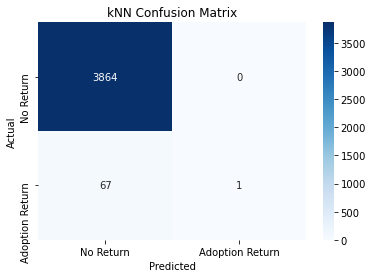

In [14]:
# sample confusion matrix; curious to know why precision was so high when neighbors is 2
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

plot_confusion_matrix(y_test, knn_pred, "kNN")

In [15]:
# oversample my minority class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [16]:
# kNN on data that's oversampled (5 times the amount of adoption returns)
knn_results_os = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_os, y_train_os)
    knn_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, knn_pred)
    precision, recall, fscore, support = prfs_score(y_test, knn_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, knn_pred)
    
    model_scores_dict = {
                        'Model': 'kNN',
                        'Sampling Strategy': 'Oversampled by 5',
                        'Parameter_1': f'Neighbors: {i}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    knn_results_os.append(model_scores_dict)
                       
knn_results_os_df = pd.DataFrame(data=knn_results_os)
knn_results_os_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,kNN,Oversampled by 5,Neighbors: 1,NaN,0.96,0.07,0.10,0.08,0.54
1,kNN,Oversampled by 5,Neighbors: 2,NaN,0.97,0.06,0.04,0.05,0.52
2,kNN,Oversampled by 5,Neighbors: 3,NaN,0.96,0.05,0.06,0.05,0.52
3,kNN,Oversampled by 5,Neighbors: 4,NaN,0.97,0.06,0.06,0.06,0.52
4,kNN,Oversampled by 5,Neighbors: 5,NaN,0.96,0.06,0.09,0.07,0.53
5,kNN,Oversampled by 5,Neighbors: 6,NaN,0.96,0.05,0.06,0.05,0.52
6,kNN,Oversampled by 5,Neighbors: 7,NaN,0.96,0.05,0.09,0.07,0.53
7,kNN,Oversampled by 5,Neighbors: 8,NaN,0.97,0.06,0.07,0.07,0.53
8,kNN,Oversampled by 5,Neighbors: 9,NaN,0.96,0.05,0.09,0.07,0.53


In [17]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

In [18]:
# kNN on data that's undersampled (half the amount of non adoption returns)
knn_results_us = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_us, y_train_us)
    knn_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, knn_pred)
    precision, recall, fscore, support = prfs_score(y_test, knn_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, knn_pred)
    
    model_scores_dict = {
                        'Model': 'kNN',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'neighbors={i}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    knn_results_us.append(model_scores_dict)
                       
knn_results_us_df = pd.DataFrame(data=knn_results_us)
knn_results_us_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,kNN,Undersampled by 0.5,neighbors=1,NaN,0.97,0.07,0.07,0.07,0.53
1,kNN,Undersampled by 0.5,neighbors=2,NaN,0.98,0.14,0.01,0.03,0.51
2,kNN,Undersampled by 0.5,neighbors=3,NaN,0.98,0.07,0.01,0.02,0.51
3,kNN,Undersampled by 0.5,neighbors=4,NaN,0.98,0.00,0.00,0.00,0.50
4,kNN,Undersampled by 0.5,neighbors=5,NaN,0.98,0.33,0.01,0.03,0.51
5,kNN,Undersampled by 0.5,neighbors=6,NaN,0.98,0.00,0.00,0.00,0.50
6,kNN,Undersampled by 0.5,neighbors=7,NaN,0.98,0.00,0.00,0.00,0.50
7,kNN,Undersampled by 0.5,neighbors=8,NaN,0.98,0.00,0.00,0.00,0.50
8,kNN,Undersampled by 0.5,neighbors=9,NaN,0.98,0.00,0.00,0.00,0.50


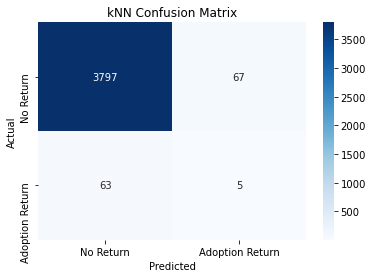

In [20]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_us, y_train_us)
knn_pred = knn.predict(X_test)

plot_confusion_matrix(y_test, knn_pred, "kNN")

Overall thoughts on kNN. The results without oversampling or undersampling are not good. The ROC/AUC score is 0.5, which means there's no separation between the positive (adoption return) and negative (no adoption return) class. There's high accuracy, but that's because my dataset is imbalanced.

Oversampling and undersampling didn't produce great results.

My overall goal is to maximize ROC/AUC score as well as the Recall metric. I want a higher recall score because I want my model to capture all the animals that were adoption returns. The third metric I'm looking at is f-score. I want my model to maximize the number of true positives and true negatives and minimize the amount of false positives and false negatives.

### 4. Decision Tree

In [21]:
# make a bunch of decision trees with different max depths
tree_list = []
for i in range(5,16):
    dec_tree = DecisionTreeClassifier(max_depth=i)
    tree_list.append(dec_tree)

In [22]:
# for decision tree models, I still need to make dummy variables, but I don't need to scale my age column
# I also don't need to drop any dummy variables
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [23]:
dec_tree_results = []
for i, tree in enumerate(tree_list):
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_test)
    
    accuracy = accuracy_score(y_test, tree_pred)
    precision, recall, fscore, support = prfs_score(y_test, tree_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, tree_pred)
    
    model_scores_dict = {
                        'Model': 'Decision Tree',
                        'Sampling Strategy': 'None',
                        'Parameter_1': f'Max Depth: {i+5}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    dec_tree_results.append(model_scores_dict)

dec_tree_results_df = pd.DataFrame(data=dec_tree_results)
dec_tree_results_df # nothing interesting to see

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Decision Tree,None,Max Depth: 5,NaN,0.98,0.00,0.00,0.00,0.50
1,Decision Tree,None,Max Depth: 6,NaN,0.98,0.50,0.01,0.03,0.51
2,Decision Tree,None,Max Depth: 7,NaN,0.98,0.40,0.03,0.05,0.51
3,Decision Tree,None,Max Depth: 8,NaN,0.98,0.40,0.03,0.05,0.51
4,Decision Tree,None,Max Depth: 9,NaN,0.98,0.33,0.04,0.08,0.52
5,Decision Tree,None,Max Depth: 10,NaN,0.98,0.44,0.06,0.10,0.53
6,Decision Tree,None,Max Depth: 11,NaN,0.98,0.50,0.07,0.13,0.54
7,Decision Tree,None,Max Depth: 12,NaN,0.98,0.31,0.07,0.12,0.54
8,Decision Tree,None,Max Depth: 13,NaN,0.98,0.24,0.06,0.09,0.53
9,Decision Tree,None,Max Depth: 14,NaN,0.98,0.35,0.09,0.14,0.54


In [24]:
# oversample my non positive class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [25]:
# try out decision tree on data that's oversampled
dec_tree_results_os = []

for i, tree in enumerate(tree_list):
    tree.fit(X_train_os, y_train_os)
    tree_pred = tree.predict(X_test)
    
    accuracy = accuracy_score(y_test, tree_pred)
    precision, recall, fscore, support = prfs_score(y_test, tree_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, tree_pred)
    
    model_scores_dict = {
                        'Model': 'Decision Tree',
                        'Sampline Strategy': 'Oversampled By 5',
                        'Parameter_1': f'Max Depth: {i+5}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    dec_tree_results_os.append(model_scores_dict)
                    
dec_tree_results_os_df = pd.DataFrame(data=dec_tree_results_os)
dec_tree_results_os_df # AUC score is still terrible (around 0.5; best one is max depth 14?)

,Model,Sampline Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Decision Tree,Oversampled By 5,Max Depth: 5,NaN,0.98,0.33,0.10,0.16,0.55
1,Decision Tree,Oversampled By 5,Max Depth: 6,NaN,0.98,0.30,0.09,0.14,0.54
2,Decision Tree,Oversampled By 5,Max Depth: 7,NaN,0.98,0.28,0.07,0.12,0.54
3,Decision Tree,Oversampled By 5,Max Depth: 8,NaN,0.98,0.29,0.07,0.12,0.54
4,Decision Tree,Oversampled By 5,Max Depth: 9,NaN,0.98,0.29,0.07,0.12,0.54
5,Decision Tree,Oversampled By 5,Max Depth: 10,NaN,0.98,0.31,0.07,0.12,0.54
6,Decision Tree,Oversampled By 5,Max Depth: 11,NaN,0.98,0.28,0.12,0.16,0.56
7,Decision Tree,Oversampled By 5,Max Depth: 12,NaN,0.98,0.29,0.10,0.15,0.55
8,Decision Tree,Oversampled By 5,Max Depth: 13,NaN,0.98,0.21,0.15,0.17,0.57
9,Decision Tree,Oversampled By 5,Max Depth: 14,NaN,0.97,0.16,0.13,0.15,0.56


In [26]:
# create a list of different class weights
weight_list = []
for i in range(1, 10):
    weight_dict = {0:1, 1:i}
    weight_list.append(weight_dict)

In [27]:
# oversample my minority class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [28]:
# Oversample data and adjust class weights with decision tree
# I increased my AUC score from 0.5 to 0.6. However the accuracy and precision suffers a lot
dec_tree_results_os_weights = []
for weight in weight_list:
    tree = DecisionTreeClassifier(max_depth=14, class_weight=weight)
    tree.fit(X_train_os, y_train_os)
    tree_pred = tree.predict(X_test)
    
    accuracy = accuracy_score(y_test, tree_pred)
    precision, recall, fscore, support = prfs_score(y_test, tree_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, tree_pred)
    
    model_scores_dict = {
                        'Model': 'Decision Tree',
                        'Sampling Strategy': 'Oversample By 5',
                        'Parameter_1': f'Max Depth: 14',
                        'Parameter_2': f'Class Weight: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    dec_tree_results_os_weights.append(model_scores_dict)

dec_tree_results_os_weights_df = pd.DataFrame(data=dec_tree_results_os_weights)
dec_tree_results_os_weights_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 1}",0.97,0.15,0.12,0.13,0.55
1,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 2}",0.95,0.11,0.29,0.16,0.63
2,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 3}",0.94,0.09,0.28,0.14,0.61
3,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 4}",0.90,0.07,0.35,0.11,0.63
4,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 5}",0.88,0.06,0.38,0.10,0.64
5,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 6}",0.88,0.06,0.41,0.10,0.65
6,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 7}",0.85,0.06,0.49,0.10,0.67
7,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 8}",0.84,0.05,0.50,0.10,0.67
8,Decision Tree,Overesample By 5,Max Depth: 14,"Class Weight: {0: 1, 1: 9}",0.81,0.05,0.49,0.08,0.65


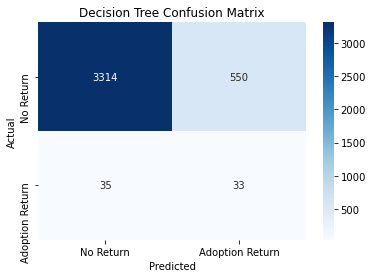

In [29]:
# look at a confusion matrix
tree = DecisionTreeClassifier(max_depth=14, class_weight={0:1, 1:7})
tree.fit(X_train_os, y_train_os)
tree_pred = tree.predict(X_test)
plot_confusion_matrix(y_test, tree_pred, "Decision Tree")

In [30]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)
weight_list = []
for i in range(1, 10):
    weight_dict = {0:1, 1:i}
    weight_list.append(weight_dict)
    
dec_tree_results_us_weights = []
for weight in weight_list:
    tree = DecisionTreeClassifier(max_depth=14, class_weight=weight)
    tree.fit(X_train_us, y_train_us)
    tree_pred = tree.predict(X_test)
    
    accuracy = accuracy_score(y_test, tree_pred)
    precision, recall, fscore, support = prfs_score(y_test, tree_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, tree_pred)
    
    model_scores_dict = {
                        'Model': 'Decision Tree',
                        'Sampling Strategy': 'Undersample By 0.5',
                        'Parameter_1': f'Max Depth: 14',
                        'Parameter_2': f'Class Weight: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    dec_tree_results_us_weights.append(model_scores_dict)

dec_tree_results_us_weights_df = pd.DataFrame(data=dec_tree_results_us_weights)
dec_tree_results_us_weights_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 1}",0.98,0.18,0.10,0.13,0.55
1,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 2}",0.97,0.12,0.12,0.12,0.55
2,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 3}",0.96,0.12,0.18,0.14,0.58
3,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 4}",0.96,0.12,0.21,0.15,0.59
4,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 5}",0.94,0.11,0.37,0.17,0.66
5,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 6}",0.93,0.10,0.37,0.16,0.66
6,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 7}",0.93,0.11,0.40,0.17,0.67
7,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 8}",0.91,0.06,0.25,0.09,0.59
8,Decision Tree,Undersample By 0.5,Max Depth: 14,"Class Weight: {0: 1, 1: 9}",0.89,0.06,0.34,0.10,0.62


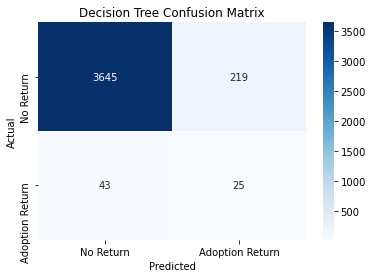

In [31]:
# look at a confusion matrix
tree = DecisionTreeClassifier(max_depth=14, class_weight={0:1, 1:6})
tree.fit(X_train_us, y_train_us)
tree_pred = tree.predict(X_test)
plot_confusion_matrix(y_test, tree_pred, "Decision Tree")

Overall thoughts on Decision Tree. ROC/AUC scores are between 0.5 and 0.7, which is better than kNN. F scores are in the 0.1 range. Adjusting class weights helps my model immensely with distinguishing adoption returns from non-returns.

### 5. Random Forest

In [32]:
# for random forest, I still need to make dummy variables, but I don't need to scale my age column
# I also don't need to drop any dummy variables
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [33]:
# oversample my minority class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [34]:
# create a list of different estimators (random forest parameter)
estimator_list = np.arange(25,301,25, dtype=int)

In [35]:
ran_forest_results = []
for estimator in estimator_list:
    forest = RandomForestClassifier(n_estimators=estimator)
    forest.fit(X_train_os, y_train_os)
    forest_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, forest_pred)
    precision, recall, fscore, support = prfs_score(y_test, forest_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, forest_pred)
    
    model_scores_dict = {
                        'Model': 'Random Forest',
                        'Sampline Strategy': 'Oversampled By 5',
                        'Parameter_1': f'Num Estimators: {estimator}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    ran_forest_results.append(model_scores_dict)
    
ran_forest_results_df = pd.DataFrame(data=ran_forest_results)
ran_forest_results_df

,Model,Sampline Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Random Forest,Oversampled By 5,Num Estimators: 25,NaN,0.96,0.09,0.12,0.10,0.55
1,Random Forest,Oversampled By 5,Num Estimators: 50,NaN,0.97,0.10,0.12,0.11,0.55
2,Random Forest,Oversampled By 5,Num Estimators: 75,NaN,0.97,0.10,0.12,0.11,0.55
3,Random Forest,Oversampled By 5,Num Estimators: 100,NaN,0.96,0.09,0.12,0.10,0.55
4,Random Forest,Oversampled By 5,Num Estimators: 125,NaN,0.97,0.10,0.12,0.11,0.55
5,Random Forest,Oversampled By 5,Num Estimators: 150,NaN,0.97,0.09,0.12,0.10,0.55
6,Random Forest,Oversampled By 5,Num Estimators: 175,NaN,0.97,0.10,0.12,0.11,0.55
7,Random Forest,Oversampled By 5,Num Estimators: 200,NaN,0.97,0.10,0.12,0.11,0.55
8,Random Forest,Oversampled By 5,Num Estimators: 225,NaN,0.97,0.10,0.12,0.11,0.55
9,Random Forest,Oversampled By 5,Num Estimators: 250,NaN,0.96,0.09,0.12,0.10,0.55


In [36]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

In [37]:
ran_forest_results = []
for estimator in estimator_list:
    forest = RandomForestClassifier(n_estimators=estimator)
    forest.fit(X_train_us, y_train_us)
    forest_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, forest_pred)
    precision, recall, fscore, support = prfs_score(y_test, forest_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, forest_pred)
    
    model_scores_dict = {
                        'Model': 'Random Forest',
                        'Sampline Strategy': 'Undersampled By 5',
                        'Parameter_1': f'Num Estimators: {estimator}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    ran_forest_results.append(model_scores_dict)
    
ran_forest_results_df = pd.DataFrame(data=ran_forest_results)
ran_forest_results_df

,Model,Sampline Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Random Forest,Undersampled By 5,Num Estimators: 25,NaN,0.98,0.09,0.04,0.06,0.52
1,Random Forest,Undersampled By 5,Num Estimators: 50,NaN,0.98,0.13,0.06,0.08,0.53
2,Random Forest,Undersampled By 5,Num Estimators: 75,NaN,0.98,0.11,0.06,0.08,0.53
3,Random Forest,Undersampled By 5,Num Estimators: 100,NaN,0.98,0.11,0.06,0.08,0.53
4,Random Forest,Undersampled By 5,Num Estimators: 125,NaN,0.98,0.13,0.06,0.08,0.53
5,Random Forest,Undersampled By 5,Num Estimators: 150,NaN,0.98,0.13,0.06,0.08,0.53
6,Random Forest,Undersampled By 5,Num Estimators: 175,NaN,0.98,0.12,0.06,0.08,0.53
7,Random Forest,Undersampled By 5,Num Estimators: 200,NaN,0.98,0.12,0.06,0.08,0.53
8,Random Forest,Undersampled By 5,Num Estimators: 225,NaN,0.98,0.12,0.06,0.08,0.53
9,Random Forest,Undersampled By 5,Num Estimators: 250,NaN,0.98,0.12,0.06,0.08,0.53


In [38]:
weight_list = []
for i in range(1, 10):
    weight_dict = {0:1, 1:i}
    weight_list.append(weight_dict)

In [39]:
# changing class weights on oversampled data
ran_forest_weight_results = []
for weight in weight_list:
    forest = RandomForestClassifier(n_estimators=100, class_weight=weight)
    forest.fit(X_train_os, y_train_os)
    forest_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, forest_pred)
    precision, recall, fscore, support = prfs_score(y_test, forest_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, forest_pred)
    
    model_scores_dict = {
                        'Model': 'Random Forest',
                        'Sampling Strategy': 'Oversampled By 5',
                        'Parameter_1': f'Num Estimators: 100',
                        'Parameter_2': f'Class weight: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    ran_forest_weight_results.append(model_scores_dict)
    
ran_forest_weight_results_df = pd.DataFrame(data=ran_forest_weight_results)
ran_forest_weight_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 1}",0.97,0.10,0.12,0.11,0.55
1,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 2}",0.95,0.08,0.19,0.11,0.58
2,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 3}",0.94,0.07,0.21,0.10,0.58
3,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 4}",0.93,0.07,0.24,0.10,0.59
4,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 5}",0.92,0.06,0.25,0.09,0.59
5,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 6}",0.91,0.05,0.26,0.09,0.59
6,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 7}",0.90,0.05,0.26,0.09,0.59
7,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 8}",0.90,0.05,0.28,0.09,0.60
8,Random Forest,Oversampled By 5,Num Estimators: 100,"Class weight: {0: 1, 1: 9}",0.90,0.05,0.28,0.09,0.59


In [40]:
# changing class weights on undersampled data
ran_forest_weight_results = []
for weight in weight_list:
    forest = RandomForestClassifier(n_estimators=100, class_weight=weight)
    forest.fit(X_train_us, y_train_us)
    forest_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, forest_pred)
    precision, recall, fscore, support = prfs_score(y_test, forest_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, forest_pred)
    
    model_scores_dict = {
                        'Model': 'Random Forest',
                        'Sampling Strategy': 'Undersampled By 0.5',
                        'Parameter_1': f'Num Estimators: 100',
                        'Parameter_2': f'Class weight: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    ran_forest_weight_results.append(model_scores_dict)
    
ran_forest_weight_results_df = pd.DataFrame(data=ran_forest_weight_results)
ran_forest_weight_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 1}",0.98,0.12,0.06,0.08,0.53
1,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 2}",0.97,0.12,0.09,0.10,0.54
2,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 3}",0.97,0.08,0.09,0.09,0.54
3,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 4}",0.96,0.07,0.10,0.09,0.54
4,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 5}",0.96,0.06,0.10,0.08,0.54
5,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 6}",0.95,0.08,0.15,0.10,0.56
6,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 7}",0.95,0.07,0.13,0.09,0.55
7,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 8}",0.95,0.06,0.12,0.08,0.54
8,Random Forest,Undersampled By 0.5,Num Estimators: 100,"Class weight: {0: 1, 1: 9}",0.95,0.08,0.18,0.11,0.57


In [41]:
# undersample my majority class by a quarter
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.25)

ran_forest_weight_results = []
for weight in weight_list:
    forest = RandomForestClassifier(n_estimators=100, class_weight=weight)
    forest.fit(X_train_us, y_train_us)
    forest_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, forest_pred)
    precision, recall, fscore, support = prfs_score(y_test, forest_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, forest_pred)
    
    model_scores_dict = {
                        'Model': 'Random Forest',
                        'Sampling Strategy': 'Undersampled By 0.25',
                        'Parameter_1': f'Num Estimators: 100',
                        'Parameter_2': f'Class weight: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    ran_forest_weight_results.append(model_scores_dict)
    
ran_forest_weight_results_df = pd.DataFrame(data=ran_forest_weight_results)
ran_forest_weight_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 1}",0.97,0.12,0.12,0.12,0.55
1,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 2}",0.96,0.09,0.15,0.11,0.56
2,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 3}",0.95,0.09,0.18,0.12,0.57
3,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 4}",0.95,0.07,0.16,0.10,0.56
4,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 5}",0.94,0.08,0.22,0.12,0.59
5,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 6}",0.94,0.08,0.24,0.12,0.59
6,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 7}",0.93,0.08,0.26,0.12,0.60
7,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 8}",0.92,0.06,0.25,0.10,0.59
8,Random Forest,Undersampled By 0.25,Num Estimators: 100,"Class weight: {0: 1, 1: 9}",0.93,0.07,0.25,0.11,0.60


Overall thoughts on Random Forest. It seems like it performs worse than Decision Tree. ROC/AUC scores are between 0.5 and 0.6, which is worse than Decision Tree. F scores are in the 0.1 range. I'm not really impressed with Random Forest metrics.

### 6. Logistic Regression

In [42]:
# with LogisticRegression, I need to drop dummy variables
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
drop_dummy_columns = ["type_OTHER", "gender_Unknown", "size_X-LRG", "intake_condition_UNKNOWN", "intake_location_UNKNOWN"]
X = X.drop(columns=drop_dummy_columns)

y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [43]:
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [44]:
C_list = [0.1, 0.5, 1, 3, 5, 10]

log_reg_results = []
for C_value in C_list:
    logreg = LogisticRegression(C=C_value, max_iter=500)
    logreg.fit(X_train, y_train)
    logreg_pred = logreg.predict(X_test)
    
    accuracy = accuracy_score(y_test, logreg_pred)
    precision, recall, fscore, support = prfs_score(y_test, logreg_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, logreg_pred)
    
    model_scores_dict = {
                        'Model': 'Logistic Regression',
                        'Sampling Strategy': 'None',
                        'Parameter_1': f'C value: {C_value}',
                        'Parameter_2': np.nan,
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    log_reg_results.append(model_scores_dict)

log_reg_results_df = pd.DataFrame(data=log_reg_results)
log_reg_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Logistic Regression,None,C value: 0.1,NaN,0.98,0.0,0.0,0.0,0.5
1,Logistic Regression,None,C value: 0.5,NaN,0.98,0.0,0.0,0.0,0.5
2,Logistic Regression,None,C value: 1,NaN,0.98,0.0,0.0,0.0,0.5
3,Logistic Regression,None,C value: 3,NaN,0.98,0.0,0.0,0.0,0.5
4,Logistic Regression,None,C value: 5,NaN,0.98,0.0,0.0,0.0,0.5
5,Logistic Regression,None,C value: 10,NaN,0.98,0.0,0.0,0.0,0.5


In [45]:
weight_list = []
for i in range(1, 10):
    weight_dict = {0:1, 1:i}
    weight_list.append(weight_dict)

In [46]:
# Changing the class weights really helped the AUC score, but accuracy decreased a lot
log_reg_results_weights = []
for weight in weight_list:
    logreg = LogisticRegression(C=1, max_iter=1000, class_weight=weight)
    logreg.fit(X_train_os, y_train_os)
    logreg_pred = logreg.predict(X_test)
    
    accuracy = accuracy_score(y_test, logreg_pred)
    precision, recall, fscore, support = prfs_score(y_test, logreg_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, logreg_pred)
    
    model_scores_dict = {
                        'Model': 'Logistic Regression',
                        'Sampling Strategy': 'Oversampled by 5',
                        'Parameter_1': f'C value: 1',
                        'Parameter_2': f'Class Weights: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    log_reg_results_weights.append(model_scores_dict)
    
log_reg_results_weights_df = pd.DataFrame(data=log_reg_results_weights)
log_reg_results_weights_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 1}",0.98,0.27,0.10,0.15,0.55
1,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 2}",0.98,0.27,0.16,0.20,0.58
2,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 3}",0.97,0.20,0.18,0.19,0.58
3,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 4}",0.95,0.10,0.24,0.14,0.60
4,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 5}",0.90,0.07,0.38,0.12,0.65
5,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 6}",0.83,0.05,0.53,0.10,0.68
6,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 7}",0.78,0.05,0.60,0.09,0.69
7,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 8}",0.74,0.04,0.69,0.08,0.72
8,Logistic Regression,Oversampled by 5,C value: 1,"Class Weights: {0: 1, 1: 9}",0.70,0.04,0.78,0.08,0.74


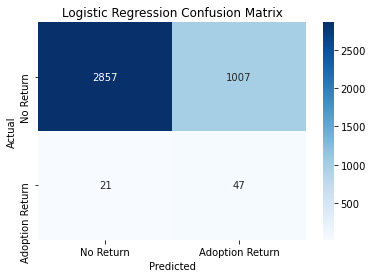

In [47]:
logreg = LogisticRegression(C=1, max_iter=1000, class_weight={0:1, 1:8})
logreg.fit(X_train_os, y_train_os)
logreg_pred = logreg.predict(X_test)
plot_confusion_matrix(y_test, logreg_pred, "Logistic Regression")

In [48]:
# trying out undersampling and class weights

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

log_reg_results_weights = []
for weight in weight_list:
    logreg = LogisticRegression(C=1, max_iter=1000, class_weight=weight)
    logreg.fit(X_train_us, y_train_us)
    logreg_pred = logreg.predict(X_test)
    
    accuracy = accuracy_score(y_test, logreg_pred)
    precision, recall, fscore, support = prfs_score(y_test, logreg_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, logreg_pred)
    
    model_scores_dict = {
                        'Model': 'Logistic Regression',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'C value: 1',
                        'Parameter_2': f'Class Weights: {weight}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    log_reg_results_weights.append(model_scores_dict)
    
log_reg_results_weights_df = pd.DataFrame(data=log_reg_results_weights)
log_reg_results_weights_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 1}",0.98,0.00,0.00,0.00,0.50
1,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 2}",0.98,0.33,0.07,0.12,0.54
2,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 3}",0.98,0.31,0.15,0.20,0.57
3,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 4}",0.98,0.28,0.16,0.20,0.58
4,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 5}",0.98,0.26,0.18,0.21,0.58
5,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 6}",0.98,0.28,0.19,0.23,0.59
6,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 7}",0.98,0.24,0.19,0.21,0.59
7,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 8}",0.97,0.20,0.21,0.20,0.60
8,Logistic Regression,Undersampled by 0.5,C value: 1,"Class Weights: {0: 1, 1: 9}",0.97,0.17,0.24,0.20,0.61


Overall, Logistic Regression performed well. F scores are generally higher, in the 0.1 to 0.2 range, and ROC/AUC scores went as high as 0.7. Also, some of the recall scores were very high (although precision was very low). So far, out of all the models I've tested, Logistic Regression has the highest scores for the metrics I care about.

### 7. Trying out Naive Bayes

Naive Bayes only works with just continous or just binary features. I'll need to transform my data to match that format.

In [49]:
# I use dummy variables to represent categorical features as binary features
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)

# my age column, which is currently a numeric column, needs to be turned into a binary feature
mean_age = X["age"].mean()
X["over_mean_age"] = X["age"].apply(lambda x: 0 if x < mean_age else 1)
X.drop(columns=["age"], inplace=True)

In [50]:
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [51]:
# oversample my minority class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [52]:
# Bayes doesn't have a great ROC AUC score
bayes = BernoulliNB()
bayes.fit(X_train_os, y_train_os)
bayes_pred = bayes.predict(X_test)

bayes_results = []

accuracy = accuracy_score(y_test, bayes_pred)
precision, recall, fscore, support = prfs_score(y_test, bayes_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, bayes_pred)

model_scores_dict = {
                        'Model': 'Naive Bayes',
                        'Sampling Strategy': 'Oversampled by 5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
bayes_results.append(model_scores_dict)
    
bayes_results_df = pd.DataFrame(data=bayes_results)
bayes_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Naive Bayes,Oversampled by 5,None,None,0.98,0.24,0.13,0.17,0.56


In [53]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

In [54]:
# Bayes still doesn't have a great ROC AUC score
bayes = BernoulliNB()
bayes.fit(X_train_us, y_train_us)
bayes_pred = bayes.predict(X_test)

bayes_results = []

accuracy = accuracy_score(y_test, bayes_pred)
precision, recall, fscore, support = prfs_score(y_test, bayes_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, bayes_pred)

model_scores_dict = {
                        'Model': 'Naive Bayes',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
bayes_results.append(model_scores_dict)
    
bayes_results_df = pd.DataFrame(data=bayes_results)
bayes_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,Naive Bayes,Undersampled by 0.5,None,None,0.98,0.36,0.07,0.12,0.54


Overall thoughts on Naive Bayes. ROC/AUC scores are not super high. F scores are okay (in the 0.1 range). However, Logistic Regression seems to have high scores in the metrics I care about, especially with Recall.

### 8. Trying out XGBoost

Data should be formatted similar to Decision Tree or Random Forest

In [55]:
# for XGBoost, I still need to make dummy variables, but I don't need to scale my age column
# I also don't need to drop any dummy variables
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [63]:
xgboost = xgb.XGBClassifier(
                           n_estimators=3000, # arbitrary large number
                           max_depth=3,
                           objective='binary:logistic',
                           learning_rate=0.05,
                           subsample=1,
                           min_child_weight=1
                           )
eval_set = [(X_train, y_train), (X_test, y_test)] # tracking train/validation error as we go

fit_model = xgboost.fit(
                        X_train, y_train,
                        eval_set = eval_set,
                        eval_metric='error',
                        early_stopping_rounds=50,
                        verbose=False
                        )

In [64]:
# initial results from XGBoost don't look good
xgboost_pred = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost',
                        'Sampling Strategy': 'None',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,None,None,None,0.98,0.5,0.01,0.03,0.51


In [65]:
# oversample my minority class by 5
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

In [67]:
xgboost = xgb.XGBClassifier(
                           n_estimators=3000, # arbitrary large number
                           max_depth=12,
                           objective='binary:logistic',
                           learning_rate=0.1,
                           subsample=0.8,
                           min_child_weight=3
                           )
eval_set = [(X_train_os, y_train_os), (X_test, y_test)] # tracking train/validation error as we go

fit_model = xgboost.fit(
                        X_train_os, y_train_os,
                        eval_set = eval_set,
                        eval_metric='auc',
                        early_stopping_rounds=50,
                        verbose=False
                        )

In [68]:
# XGBoost with oversampled data

xgboost_pred = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost',
                        'Sampling Strategy': 'Oversampled by 5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,Oversampled by 5,None,None,0.98,0.24,0.12,0.16,0.56


In [69]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

In [70]:
# trying out RandomizedSearchCV to do a quick and dirty hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators_range = [100, 500, 1000, 2000, 3000, 5000]
max_depth_range = [x for x in range(10,31)]
learning_rate_range = list(np.linspace(0,1,10, endpoint=False))
subsample_range = list(np.linspace(0.3,1,7,endpoint=False))

param_grid = dict(n_estimators=n_estimators_range,
                  max_depth=max_depth_range,
                  objective=['binary:logistic'],
                  learning_rate=learning_rate_range,
                  subsample=subsample_range
                 )
xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc')

In [71]:
fit_model = xgboost_search.fit(X_train_us, y_train_us)

In [72]:
fit_model.best_params_

{'subsample': 0.39999999999999997,
 'objective': 'binary:logistic',
 'n_estimators': 100,
 'max_depth': 17,
 'learning_rate': 0.4}

In [73]:
# XGboost gives one of the higher F scores, recall is still very low
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 0.5,None,None,0.98,0.21,0.1,0.14,0.55


In [74]:
# undersample my majority class by half, scaling positive weight by 10
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

xgboost = xgb.XGBClassifier(
                           n_estimators=100, # arbitrary large number
                           max_depth=30,
                           objective='binary:logistic',
                           learning_rate=0.2,
                           subsample=0.4,
                           min_child_weight=3,
                           scale_pos_weight=10 # trying out a scaling factor
                           )
fit_model = xgboost.fit(X_train_us, y_train_us)

xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,Undersampled by 0.5,None,None,0.93,0.08,0.28,0.13,0.61


In [75]:
# undersample my majority class by a quarter, scaling positive weight by 10
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.25)

xgboost = xgb.XGBClassifier(
                           n_estimators=100, # arbitrary large number
                           max_depth=30,
                           objective='binary:logistic',
                           learning_rate=0.2,
                           subsample=0.4,
                           min_child_weight=3,
                           scale_pos_weight=10 # trying out a scaling factor
                           )
fit_model = xgboost.fit(X_train_us, y_train_us)

xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost',
                        'Sampling Strategy': 'Undersampled by 0.25',
                        'Parameter_1': f'Class Weight positive factor 10',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,Undersampled by 0.25,Class Weight positive factor 10,None,0.88,0.07,0.44,0.11,0.67


Results look the most promising. High F-score, high ROC/AUC score, and high recall without sacrificing too much accuracy. I will want to explore XGBoost more and fine tune the parameters.

### 9. Final Model Selection
In this section, I plot ROC curves to determine the best final model to use for my classification algorithm. I am comparing just the models where I undersample the data. Because I have such a huge class imbalance, it makes more sense for me to undersample rather than oversample to prevent overfitting. I don't want my model to be overfit to my data, and I'm less worried about losing some data points due to undersampling.

In [76]:
class_df.head()

,type,size,age,gender,has_name,spay_neuter,intake_condition,pit_bull,intake_location,adopt_return
0,DOG,MED,5.0,Male,1,0,UNKNOWN,0,SANTA ROSA,0
1,DOG,MED,7.0,Female,0,0,HEALTHY,1,SONOMA COUNTY,0
2,DOG,MED,7.0,Female,1,0,HEALTHY,0,SONOMA COUNTY,0
3,DOG,SMALL,6.0,Male,1,1,UNKNOWN,0,SANTA ROSA,0
4,DOG,LARGE,10.0,Female,1,1,HEALTHY,0,SANTA ROSA,0


In [159]:
# list to collect all the models and information to plot ROC curves
roc_model_list = []

In [160]:
def model_roc_curve(model, model_name, X_train, y_train, X_test, y_test):
    '''
    This function adds the false and true positive rates for a model
    to a list so that they can all be plotted against one another.
    Input:
    - model: the classification model (kNN, random forest, etc.)
    - X_train (DataFrame): dataframe of features to train the model
    - y_train (Series): series of target feature to train the model
    - X_test (DataFrame): dataframe of features to test the model
    - y_test (Series): series of target feature to train the model
    '''
    model.fit(X_train, y_train)
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    pred = model.predict(X_test)
    roc_score = roc_auc_score(y_test, pred)
    roc_curve_dict = {
                      'Model': model_name + ' ' + str(round(roc_score,3)),
                      'fpr': fpr,
                      'tpr': tpr
                      }
    roc_model_list.append(roc_curve_dict)

In [161]:
# model for kNN
X = class_df.drop(columns=["adopt_return"])
scaler = StandardScaler()
X["age"] = scaler.fit_transform(X["age"].values.reshape(-1,1))
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

knn = KNeighborsClassifier(n_neighbors=1)
model_roc_curve(knn, 'kNN', X_train_us, y_train_us, X_test, y_test)

In [162]:
# model for decision tree
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

tree = DecisionTreeClassifier(max_depth=14, class_weight={0:1, 1:3})
model_roc_curve(tree, 'Decision Tree', X_train_us, y_train_us, X_test, y_test)

In [163]:
# model for random forest
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

forest = RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:9})
model_roc_curve(forest, 'Random Forest', X_train_us, y_train_us, X_test, y_test)

In [164]:
# model for logistic regression
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
drop_dummy_columns = ["type_OTHER", "gender_Unknown", "size_X-LRG", "intake_condition_UNKNOWN", "intake_location_UNKNOWN"]
X = X.drop(columns=drop_dummy_columns)

y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

logreg = LogisticRegression(C=1, max_iter=1000, class_weight={0:1, 1:9})
model_roc_curve(logreg, 'Logistic Regression', X_train_us, y_train_us, X_test, y_test)

In [165]:
# model for Naive Bayes
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)

# my age column, which is currently a numeric column, needs to be turned into a binary feature
mean_age = X["age"].mean()
X["over_mean_age"] = X["age"].apply(lambda x: 0 if x < mean_age else 1)
X.drop(columns=["age"], inplace=True)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)
bayes = BernoulliNB()
model_roc_curve(bayes, 'Naive Bayes', X_train_us, y_train_us, X_test, y_test)

In [166]:
# model for XGBoost
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

xgboost = xgb.XGBClassifier(
                           n_estimators=100,
                           max_depth=30,
                           objective='binary:logistic',
                           learning_rate=0.2,
                           subsample=0.4,
                           min_child_weight=3,
                           scale_pos_weight=10 # trying out a scaling factor
                           )
model_roc_curve(xgboost, 'XGBoost', X_train_us, y_train_us, X_test, y_test)

In [3]:
pal = sns.color_palette("Reds")
print(pal.as_hex())
pal = sns.color_palette("Blues")
print(pal.as_hex())

['#fedbcc', '#fcaf93', '#fc8161', '#f44f39', '#d52221', '#aa1016']
['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']


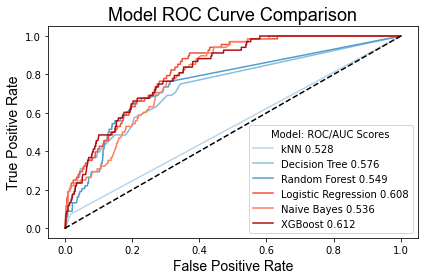

In [170]:
color_list = ['#bad6eb', '#89bedc', '#539ecd', '#f44f39', '#fc8161', '#aa1016']

fig, ax = plt.subplots()

for i, item in enumerate(roc_model_list):
    color_ = color_list[i]
    plt.plot(item['fpr'], item['tpr'], color=color_, label=item['Model'])
    plt.legend()

legend = ax.legend(loc="lower right")
legend.set_title("Model: ROC/AUC Scores")
    
plt.xlabel("False Positive Rate", fontname="Arial", fontsize=14)
plt.ylabel("True Positive Rate", fontname="Arial", fontsize=14)
plt.title("Model ROC Curve Comparison", fontname="Arial", fontsize=18)
plt.plot(np.arange(0,1.05,0.05),np.arange(0,1.05,0.05), linestyle='--', color='black')
plt.tight_layout()
plt.savefig('images/model_roc_comparison.png', format='png');

Final thoughts: The best models I have are XGBoost and Logistic Regression. There are 2 main reasons why I am choosing XGBoost over Logistic Regression to build my final model.<br/>
1. With logistic regression, I have to drop one of my dummy variables to avoid the dummy variable trap. With XGBoost, I can keep all of my dummy variables.
2. XGBoost has higher optimization and hyperparameter tuning than Logistic Regression. There's higher potential to build a better model with XGBoost than Logistic Regression.